# classification pipelining

This is a quick demo of machine learning model optimization through multi-step pipelining and grid search for various hyperparameter values using [sci-kit learn](http://scikit-learn.org). Many of the ideas were based on code from the [sklearn documentation](http://scikit-learn.org/stable/documentation.html), [Introduction to Machine Learning with Python](https://www.amazon.com/Introduction-Machine-Learning-Python-Scientists/dp/1449369413), and [scikit-learn Cookbook](https://www.amazon.com/scikit-learn-Cookbook-recipes-machine-learning/dp/178728638X/). It applie classification techniques to the [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) ([docs](https://en.wikipedia.org/wiki/Iris_flower_data_set)).

As classifiers, it compares performance and accuracy between a support vector classifier, a linear support vector classifier, logistic regression, and several ensemble models - random forests, Ada boosting, and gradient boosting. Where applicable to the particular model, it also normalizes the data through scaling and applies dimensionality reduction through [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) or [truncated single value decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition). 

Of particular interest is that the Iris dataset, being notoriously difficult to achieve high accuracy on because of its small sample size, inability to be linearly-seperable, small number of features and proportionate stratification for floral classes, has a ~98% score for predictive accuracy on the testing set after grid search over varying levels. Also, the training time for this pipeline isn't exactly lightspeed - because of the sheer volume of applicable hypermarameters, each model is trained on 125 combinations. This is perhaps a little excessive, given the preknowledge that most ensemble classifiers will outperform linear SVCs, etc. 

Training time on the toy dataset took about 90 seconds for me on an 8-core laptop with an Intel Core i7 processor, so this cleatly wouldn't perform well at scale on a real-world dataset. FYI.

The final model is an [AdaBoostClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) with the features reduced to 2 from 4 after SVD. Because this is a boosting model, scaling wasn't necessary, and as such, passed over in the pipeline. The weak learners are combined for an aggregate model with impressive accuracy that doesn't seem to be overfitting. 

This isn't perfect and can certainly be pushed further, but this is more an illustrative lesson on setting up effective preprocessing pipelines, persisting of the optimized model to disk via [Python pickling](https://docs.python.org/2/library/pickle.html), and basic exploratory data analysis.

## required packages 

In [51]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.datasets import load_iris, make_regression, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.externals import joblib

%matplotlib inline
sns.set_style('darkgrid')
sns.set(style='ticks', color_codes=True)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

## machine learning preprocessing pipeline

In [52]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('reduce_dim', PCA()),
    ('classify', SVC())
])

param_grid = [{
    'scaling' : [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'reduce_dim' : [PCA(), Isomap(), TruncatedSVD()],
    'reduce_dim__n_components' : [2, 3],
    'classify' : [SVC(), LinearSVC(), LogisticRegression()],
    'classify__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}, {
    'scaling' : [None],
    'reduce_dim' : [PCA(), Isomap(), TruncatedSVD()],
    'reduce_dim__n_components' : [2, 3],
    'classify' : [GaussianProcessClassifier(kernel=RBF(1.0)), KNeighborsClassifier(n_neighbors=3)]
},
    {
    'scaling' : [None],
    'reduce_dim' : [PCA(), Isomap(), TruncatedSVD()],
    'reduce_dim__n_components' : [2, 3],
    'classify' : [RandomForestClassifier()],
    'classify__n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}, {
    'scaling' : [None],
    'reduce_dim' : [PCA(), Isomap(), TruncatedSVD()],
    'reduce_dim__n_components' : [2, 3],
    'classify' : [AdaBoostClassifier(), GradientBoostingClassifier()],
    'classify__n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'classify__learning_rate' : [0.001, 0.01, 0.1, 1, 10]
}]

## train a variety of classification models over a grid of hyperparameter settings

In [62]:
grid = GridSearchCV(pipe, cv=3, n_jobs=-1, param_grid=param_grid)
iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, stratify=iris.target, random_state=36)
grid.fit(X_train, y_train)

y_predictions = grid.predict(X_test)

## evaluate accuracy

In [64]:
print('Optimal model parameters:\n\n{}\n'.format(grid.best_params_))
print('Best cross-validation score:\n--------\n{:.3f}\n'.format(grid.best_score_))
print('Test set predictive accuracy:\n--------\n{:.3f}'.format(accuracy_score(y_test, y_predictions)))

Optimal model parameters:

{'classify': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.001, n_estimators=30, random_state=None), 'classify__learning_rate': 0.001, 'classify__n_estimators': 30, 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0), 'reduce_dim__n_components': 2, 'scaling': None}

Best cross-validation score:
--------
0.981

Test set predictive accuracy:
--------
0.978


In [65]:
# view the cross-validation grid search results in a DataFrame
results_df = pd.DataFrame(grid.cv_results_)
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify,param_classify__C,param_reduce_dim,param_reduce_dim__n_components,param_scaling,param_classify__n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.024108,0.005975,0.001737,0.001718,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.001,"PCA(copy=True, iterated_power='auto', n_compon...",2,"StandardScaler(copy=True, with_mean=True, with...",NaN,...,0.944444,0.727273,0.876190,0.100818,632,0.927536,0.869565,0.944444,0.913849,0.032065
1,0.028448,0.002700,0.000000,0.000000,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.001,"PCA(copy=True, iterated_power='auto', n_compon...",2,"MinMaxScaler(copy=True, feature_range=(0, 1))",NaN,...,0.972222,0.757576,0.904762,0.099645,379,0.869565,0.840580,0.930556,0.880233,0.037499
2,0.021177,0.012198,0.000000,0.000000,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.001,"PCA(copy=True, iterated_power='auto', n_compon...",2,"RobustScaler(copy=True, quantile_range=(25.0, ...",NaN,...,0.944444,0.696970,0.857143,0.109046,721,0.869565,0.797101,0.888889,0.851852,0.039510
3,0.005327,0.001883,0.001332,0.001883,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.001,"PCA(copy=True, iterated_power='auto', n_compon...",3,"StandardScaler(copy=True, with_mean=True, with...",NaN,...,0.972222,0.757576,0.895238,0.093905,502,0.913043,0.956522,0.958333,0.942633,0.020936
4,0.005327,0.001883,0.002663,0.001883,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.001,"PCA(copy=True, iterated_power='auto', n_compon...",3,"MinMaxScaler(copy=True, feature_range=(0, 1))",NaN,...,0.972222,0.757576,0.904762,0.099645,379,0.913043,0.956522,0.944444,0.938003,0.018325


# EDA: visualize the data

In [66]:
pca = PCA(n_components=2)

X_train_prime = pca.fit_transform(X_train)
print('Dimensions before PCA: {} | Dimensions after PCA: {}'.format(X_train.shape, X_train_prime.shape))

Dimensions before PCA: (105, 4) | Dimensions after PCA: (105, 2)


In [67]:
# how much variance is explained in the first principal component?
pca.explained_variance_ratio_.sum()

0.9783568892916898

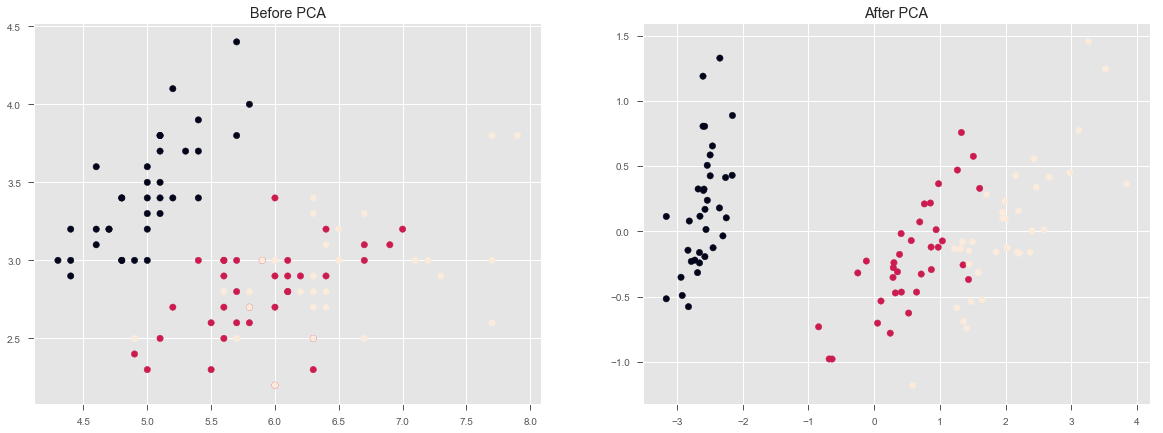

In [68]:
'''
    IMPORTANT: 
    "Even though the final dimensions of the data are 2 or 3, these 2 or 3 columns contain information from all 4 original features."
'''

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(121)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40)
ax.set_title('Before PCA')

ax2 = fig.add_subplot(122)
ax2.scatter(X_train_prime[:, 0], X_train_prime[:, 1], c=y_train, s=40)
ax2.set_title('After PCA')

plt.show()

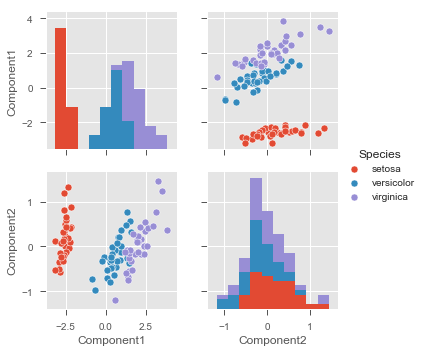

In [69]:
# plotting the decomposed data with Seaborn
df = pd.DataFrame(data=X_train_prime, columns=['Component1', 'Component2'])
df['Species'] = iris.target_names[y_train]

sns.pairplot(data=df, hue='Species')

## persist the optimized model to disk

In [70]:
grid.best_estimator_.named_steps

{'scaling': None,
 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
        random_state=None, tol=0.0),
 'classify': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=0.001, n_estimators=30, random_state=None)}

In [71]:
# serialize the top-performing model
model = grid.best_estimator_
pickle.dump(model, open('flower_classifier.pickle', 'wb'))